**FINAL PROJECT CS 634 - FALL 2019**

**RSNA Pneumonia Detection Challenge**


Project Members:
1.   Aniruddha Daware (aad65)
2.   Samantapudi Venkata Bhanudai (vs645)
3.   Sai Shivani Gondi (sg2252)

---



**APPROACH**


*   Using Convulational Neural Network we segment the image, using bounding boxes (it is a area defined by two longitudes and latitudes) directly as a mask.

*   Connected components is used to separate multiple areas of predicted pneumonia.
*   The code at the terminal end is simply a bounding box drawn around every connected component traced by the model.

*   The data is saved in a comma separated value file which gives the features along with the patient ID who are detected positive foe the pneumonia.




---



**INSTALATION OF PACKAGES**


*   Importing all the essential packages such as numpy, tenserflow, pandas, etc.
*   Pydicom is one the most essential packages as it helps to read the .dcm image files.

In [0]:
import os
import csv
import random
# To read .dcm image files
!pip install pydicom
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

     |████████████████████████████████| 7.0MB 2.6MB/s 


---

**DATA FEEDING**

Importing data from the Kaggle website and unzipping the files to a comma separated value format.



In [1]:
!wget -O label.zip "https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/download/stage_2_test_images.zip"

--2019-05-06 03:33:42--  https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/download/stage_2_test_images.zip
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.kaggle.com/account/login?ReturnUrl=%2Fc%2Frsna-pneumonia-detection-challenge%2Fdownload%2Fstage_2_test_images.zip [following]
--2019-05-06 03:33:43--  https://www.kaggle.com/account/login?ReturnUrl=%2Fc%2Frsna-pneumonia-detection-challenge%2Fdownload%2Fstage_2_test_images.zip
Reusing existing connection to www.kaggle.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘label.zip’

label.zip               [ <=>                ]   8.46K  --.-KB/s    in 0.02s   

2019-05-06 03:33:43 (543 KB/s) - ‘label.zip’ saved [8667]



In [5]:
!unzip -O label.csv label.zip

Archive:  label.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of label.zip or
        label.zip.zip, and cannot find label.zip.ZIP, period.


---

**LOAD PNEUMONIA LOCATION**


1.   The code below loads the table and transforms it into a dictionary.
2.   The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. If a filename is not present in the dictionary it means that it contains no pneumonia.

In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open('stage_2_train_labels.csv', mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [3]:
!wget -O train.zip 'https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/download/stage_2_train_images.zip'

--2019-05-06 03:34:45--  https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/download/stage_2_train_images.zip
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.kaggle.com/account/login?ReturnUrl=%2Fc%2Frsna-pneumonia-detection-challenge%2Fdownload%2Fstage_2_train_images.zip [following]
--2019-05-06 03:34:47--  https://www.kaggle.com/account/login?ReturnUrl=%2Fc%2Frsna-pneumonia-detection-challenge%2Fdownload%2Fstage_2_train_images.zip
Reusing existing connection to www.kaggle.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘train.zip’

train.zip               [ <=>                ]   8.46K  --.-KB/s    in 0.02s   

2019-05-06 03:34:47 (540 KB/s) - ‘train.zip’ saved [8667]



In [0]:
!rm -r train
!mkdir train

rm: cannot remove 'train': No such file or directory


In [0]:
#Unzipping the train files
!unzip train.zip -d train/
!rm train.zip

Archive:  train.zip
  inflating: train/a4a28a4f-9496-430c-8cc1-cff2b44ac359.dcm  
  inflating: train/93a4df4f-bb28-4f02-9e1d-4fc147a93be5.dcm  
  inflating: train/ecf0161e-f058-4166-825e-4e1d5bf98d1e.dcm  
  inflating: train/995876a0-f2ae-475b-b410-62fd0aff7f3c.dcm  
  inflating: train/f4113fee-b7a0-472c-8f68-24e999fbf73a.dcm  
  inflating: train/3d8ec01f-d488-4816-8fee-036b69b43246.dcm  
  inflating: train/5fb17b91-e490-4f40-bc6b-7955028058c8.dcm  
  inflating: train/af4d7012-0021-4729-8eda-a8393698cf33.dcm  
  inflating: train/66830592-46b6-4907-9c06-845338b63fa2.dcm  
  inflating: train/edbc1975-81dd-4296-90f6-708e3f67e81a.dcm  
  inflating: train/5d8dbcf9-0d68-4aec-8638-b0a9f45d71d6.dcm  
  inflating: train/c8b4cab0-ad2f-43dd-96e4-cd6b81f93a6a.dcm  
  inflating: train/8f0e79ea-5db6-4a83-9886-c7d58f5f4825.dcm  
  inflating: train/6249ddb9-1c22-4b28-84c4-cbc153cbb8cf.dcm  
  inflating: train/6c93d95a-2f16-46ea-88d8-84906aa27d64.dcm  
  inflating: train/a61f13b2-3055-4c31-bcd8-174baec



---



**LOAD AND SHUFFLE FILENAMES**

In [0]:
# load and shuffle filenames
folder = 'train/'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560




---



**EXPLORATION OF PNEUMONIA LOCATION**

In [0]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))


Total train images: 26684
Images with pneumonia: 6012
Minimum pneumonia height: 45
Minimum pneumonia width:  40


In [0]:
#unzipping test files
!rm -r test
!mkdir test
!wget -O test.zip 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/10338/150912/stage_2_test_images.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1557092606&Signature=h5scOwaUf0o6vrMgXswQy6hEWAWjxdgvtbTBoxY%2F4to2EYuMoYiBjTmuSBzmxl4uDYS411eUWnwSdvQiqmRu8JSA7oy9ckwekYr4vY%2BT2C8yuNUMTf5AJK58ugeJo%2BOCwxvDevaj5%2F1P1TRxliKxSPBAVqCw6jqc7nVVr5yA6x1sXiklpXyD4Eold%2FRAFY%2Fg3QCgv22cKhANmHKQqbXXQ4pKpdXhHabG6u3DNhKaGPRBawExDQ7xS%2F%2F%2F1c8zh%2FwXD4iOzWgvsOC0LaotdWFsTPNcVfiE7PIsX7I%2Fr%2BTUGVodxlFR%2F%2BAk3%2F8rKhY%2B4xmXs%2Bq5SZEJPSEoZ4pwEOzZ5g%3D%3D'
!unzip test.zip -d test/
!rm test.zip


rm: cannot remove 'test': No such file or directory
--2019-05-05 16:12:03--  https://storage.googleapis.com/kaggle-competitions-data/kaggle/10338/150912/stage_2_test_images.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1557092606&Signature=h5scOwaUf0o6vrMgXswQy6hEWAWjxdgvtbTBoxY%2F4to2EYuMoYiBjTmuSBzmxl4uDYS411eUWnwSdvQiqmRu8JSA7oy9ckwekYr4vY%2BT2C8yuNUMTf5AJK58ugeJo%2BOCwxvDevaj5%2F1P1TRxliKxSPBAVqCw6jqc7nVVr5yA6x1sXiklpXyD4Eold%2FRAFY%2Fg3QCgv22cKhANmHKQqbXXQ4pKpdXhHabG6u3DNhKaGPRBawExDQ7xS%2F%2F%2F1c8zh%2FwXD4iOzWgvsOC0LaotdWFsTPNcVfiE7PIsX7I%2Fr%2BTUGVodxlFR%2F%2BAk3%2F8rKhY%2B4xmXs%2Bq5SZEJPSEoZ4pwEOzZ5g%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 395504636 (377M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===============



---



**DATA GENERATOR**

As the data size is too large, we need to convert it into a format that loads the data in a convienent approach.

*   The generator takes in parameters and outputs a random batch of numpy images and numpy masks.

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

**NETWORK**

*   Creats a downsample and resblock for images using channels and inputs as the parameters.


In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



---



**TRAIN NETWORK**


*   It trains the data set using epochs
*   The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.
*    One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. 


In [0]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = 'train/'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=25, workers=4, use_multiprocessing=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

Epoch 1/25
752/753 [============================>.] - ETA: 1s - loss: 16.0083 - acc: 0.9610 - mean_iou: 0.6116

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 880s 1s/step - loss: 16.0060 - acc: 0.9610 - mean_iou: 0.6115 - val_loss: 15.6939 - val_acc: 0.9365 - val_mean_iou: 0.5318
Epoch 2/25
752/753 [============================>.] - ETA: 1s - loss: 14.6414 - acc: 0.9654 - mean_iou: 0.6617

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 857s 1s/step - loss: 14.6406 - acc: 0.9654 - mean_iou: 0.6616 - val_loss: 16.0802 - val_acc: 0.9698 - val_mean_iou: 0.6820
Epoch 3/25
752/753 [============================>.] - ETA: 1s - loss: 14.1585 - acc: 0.9677 - mean_iou: 0.6809

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 858s 1s/step - loss: 14.1578 - acc: 0.9677 - mean_iou: 0.6806 - val_loss: 13.8813 - val_acc: 0.9635 - val_mean_iou: 0.6495
Epoch 4/25
752/753 [============================>.] - ETA: 1s - loss: 13.7150 - acc: 0.9688 - mean_iou: 0.6884

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 861s 1s/step - loss: 13.7128 - acc: 0.9688 - mean_iou: 0.6884 - val_loss: 13.8854 - val_acc: 0.9598 - val_mean_iou: 0.6340
Epoch 5/25
752/753 [============================>.] - ETA: 1s - loss: 13.4434 - acc: 0.9697 - mean_iou: 0.6963

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 855s 1s/step - loss: 13.4430 - acc: 0.9697 - mean_iou: 0.6964 - val_loss: 16.2553 - val_acc: 0.9728 - val_mean_iou: 0.7471
Epoch 6/25
752/753 [============================>.] - ETA: 1s - loss: 13.2149 - acc: 0.9707 - mean_iou: 0.7059

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

79/80 [============================>.] - ETA: 1s - loss: 14.3932 - acc: 0.9750 - mean_iou: 0.7597

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


80/80 [==============================] - 90s 1s/step - loss: 14.4150 - acc: 0.9751 - mean_iou: 0.7603


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


753/753 [==============================] - 858s 1s/step - loss: 13.2130 - acc: 0.9707 - mean_iou: 0.7060 - val_loss: 14.4150 - val_acc: 0.9751 - val_mean_iou: 0.7603
Epoch 7/25
752/753 [============================>.] - ETA: 1s - loss: 13.0593 - acc: 0.9710 - mean_iou: 0.7090

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 858s 1s/step - loss: 13.0612 - acc: 0.9710 - mean_iou: 0.7089 - val_loss: 13.5132 - val_acc: 0.9714 - val_mean_iou: 0.7152
Epoch 8/25
752/753 [============================>.] - ETA: 1s - loss: 12.9605 - acc: 0.9715 - mean_iou: 0.7119

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

80/80 [==============================] - 89s 1s/step - loss: 13.3257 - acc: 0.9664 - mean_iou: 0.6420


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


753/753 [==============================] - 861s 1s/step - loss: 12.9602 - acc: 0.9715 - mean_iou: 0.7120 - val_loss: 13.3257 - val_acc: 0.9664 - val_mean_iou: 0.6420
Epoch 9/25
752/753 [============================>.] - ETA: 1s - loss: 12.8572 - acc: 0.9715 - mean_iou: 0.7134

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 857s 1s/step - loss: 12.8563 - acc: 0.9715 - mean_iou: 0.7134 - val_loss: 12.8572 - val_acc: 0.9680 - val_mean_iou: 0.6910
Epoch 10/25
752/753 [============================>.] - ETA: 1s - loss: 12.8169 - acc: 0.9718 - mean_iou: 0.7148

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 856s 1s/step - loss: 12.8201 - acc: 0.9718 - mean_iou: 0.7148 - val_loss: 13.6696 - val_acc: 0.9566 - val_mean_iou: 0.6228
Epoch 11/25
752/753 [============================>.] - ETA: 1s - loss: 12.7048 - acc: 0.9724 - mean_iou: 0.7201

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 863s 1s/step - loss: 12.6979 - acc: 0.9724 - mean_iou: 0.7203 - val_loss: 13.0418 - val_acc: 0.9726 - val_mean_iou: 0.7417
Epoch 12/25
752/753 [============================>.] - ETA: 1s - loss: 12.5846 - acc: 0.9727 - mean_iou: 0.7245

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 870s 1s/step - loss: 12.5838 - acc: 0.9727 - mean_iou: 0.7244 - val_loss: 12.9938 - val_acc: 0.9734 - val_mean_iou: 0.7447
Epoch 13/25
752/753 [============================>.] - ETA: 1s - loss: 12.4573 - acc: 0.9732 - mean_iou: 0.7275

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 866s 1s/step - loss: 12.4575 - acc: 0.9732 - mean_iou: 0.7275 - val_loss: 12.6144 - val_acc: 0.9719 - val_mean_iou: 0.7384
Epoch 14/25
752/753 [============================>.] - ETA: 1s - loss: 12.3651 - acc: 0.9735 - mean_iou: 0.7320

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 865s 1s/step - loss: 12.3657 - acc: 0.9735 - mean_iou: 0.7320 - val_loss: 12.4553 - val_acc: 0.9721 - val_mean_iou: 0.7218
Epoch 15/25
752/753 [============================>.] - ETA: 1s - loss: 12.2477 - acc: 0.9739 - mean_iou: 0.7386

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 866s 1s/step - loss: 12.2446 - acc: 0.9739 - mean_iou: 0.7387 - val_loss: 12.4835 - val_acc: 0.9720 - val_mean_iou: 0.7335
Epoch 16/25
752/753 [============================>.] - ETA: 1s - loss: 12.1850 - acc: 0.9741 - mean_iou: 0.7412

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 871s 1s/step - loss: 12.1912 - acc: 0.9741 - mean_iou: 0.7411 - val_loss: 12.3876 - val_acc: 0.9709 - val_mean_iou: 0.7215
Epoch 17/25
752/753 [============================>.] - ETA: 1s - loss: 12.1390 - acc: 0.9744 - mean_iou: 0.7395

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 875s 1s/step - loss: 12.1420 - acc: 0.9744 - mean_iou: 0.7394 - val_loss: 12.5400 - val_acc: 0.9740 - val_mean_iou: 0.7720
Epoch 18/25
752/753 [============================>.] - ETA: 1s - loss: 11.9920 - acc: 0.9748 - mean_iou: 0.7451

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 870s 1s/step - loss: 11.9926 - acc: 0.9748 - mean_iou: 0.7452 - val_loss: 12.3628 - val_acc: 0.9729 - val_mean_iou: 0.7480
Epoch 19/25
752/753 [============================>.] - ETA: 1s - loss: 11.9096 - acc: 0.9751 - mean_iou: 0.7471

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 868s 1s/step - loss: 11.9087 - acc: 0.9751 - mean_iou: 0.7471 - val_loss: 12.3787 - val_acc: 0.9727 - val_mean_iou: 0.7460
Epoch 20/25
752/753 [============================>.] - ETA: 1s - loss: 11.8185 - acc: 0.9756 - mean_iou: 0.7539

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 876s 1s/step - loss: 11.8189 - acc: 0.9756 - mean_iou: 0.7539 - val_loss: 12.4484 - val_acc: 0.9698 - val_mean_iou: 0.7158
Epoch 21/25
752/753 [============================>.] - ETA: 1s - loss: 11.6965 - acc: 0.9758 - mean_iou: 0.7558

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 879s 1s/step - loss: 11.6997 - acc: 0.9758 - mean_iou: 0.7558 - val_loss: 12.2948 - val_acc: 0.9728 - val_mean_iou: 0.7476
Epoch 22/25
752/753 [============================>.] - ETA: 1s - loss: 11.6617 - acc: 0.9763 - mean_iou: 0.7591

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 877s 1s/step - loss: 11.6577 - acc: 0.9763 - mean_iou: 0.7593 - val_loss: 12.3569 - val_acc: 0.9700 - val_mean_iou: 0.7211
Epoch 23/25
752/753 [============================>.] - ETA: 1s - loss: 11.6299 - acc: 0.9764 - mean_iou: 0.7604

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 875s 1s/step - loss: 11.6308 - acc: 0.9764 - mean_iou: 0.7603 - val_loss: 12.3305 - val_acc: 0.9717 - val_mean_iou: 0.7431
Epoch 24/25
752/753 [============================>.] - ETA: 1s - loss: 11.5860 - acc: 0.9764 - mean_iou: 0.7630

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

80/80 [==============================] - 92s 1s/step - loss: 12.3111 - acc: 0.9722 - mean_iou: 0.7430


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


753/753 [==============================] - 875s 1s/step - loss: 11.5907 - acc: 0.9764 - mean_iou: 0.7630 - val_loss: 12.3111 - val_acc: 0.9722 - val_mean_iou: 0.7430
Epoch 25/25
752/753 [============================>.] - ETA: 1s - loss: 11.5749 - acc: 0.9766 - mean_iou: 0.7620

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 877s 1s/step - loss: 11.5758 - acc: 0.9766 - mean_iou: 0.7620 - val_loss: 12.3157 - val_acc: 0.9722 - val_mean_iou: 0.7408




---



**LOSS AND ACCURACY**

1.  We are using jaccard loss function.The semantic segmentation describes the process of associating each pixel of an image with a class label.
2.   This loss is usefull when you have unbalanced classes within a sample such as segmenting each pixel of an image.




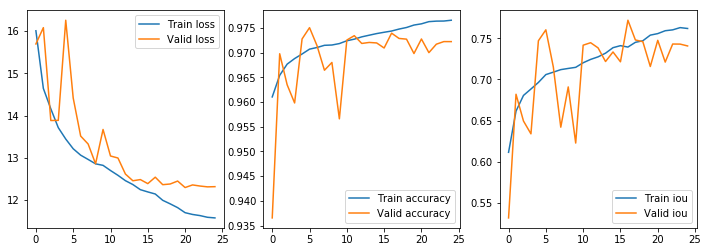

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


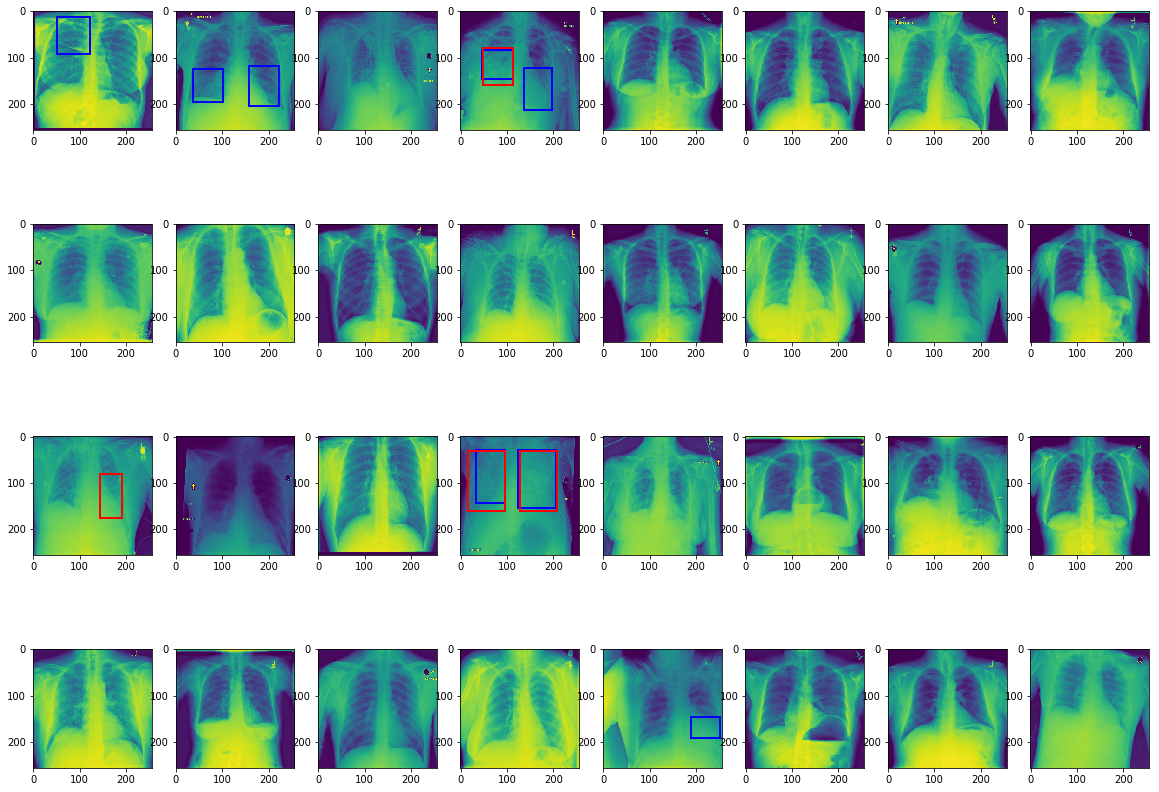

In [0]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break



---



**PREDICTION OF TEST IMAGES**


*   Creating the test sample generator applying the mask on it.
*   Drawing the bounding boxes according to the connected components.


*   Printing the submission.csv file to get the output as Patient ID and Predictionstrings



In [0]:
# load and shuffle filenames
folder = 'test/'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(sub)

n test samples: 3000


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


                                                                       PredictionString
patientId                                                                              
3090e21b-706b-4ddb-b730-a5276b953bd7  0.9441035804413218 192 128 256 512 0.874679013...
1a27e565-b0f5-4419-84b3-744712cb705d                0.7877918240424302 576 511 256 385 
0efd119a-5eba-4c61-8d9e-56380651b4d9                0.7397948804525426 193 385 255 191 
c05a341f-e8b7-438b-a8d7-146dd746a2aa                                                   
1fc7fea2-7b2e-4fe0-a74f-6f7e6ba86e4f                                                   
2ebc2dbb-9603-48b0-8cf1-20c087cebb4d                                                   
047033df-5509-4b5b-9861-351b9a0bf4c4                                                   
0550c5d5-941c-4995-9276-6401a8a4ffbe                0.7959618044840124 192 448 255 257 
20cf7cea-879e-47fe-937c-15a258dff0e3                                                   
1c7dda21-aa7e-4db4-84b3-7a039779